In [ ]:
!pip install tensorflow

In [ ]:
!pip install xgboost

In [ ]:
!pip install CatBoost

In [ ]:
!pip install lightgbm

In [1]:
#Libraries For Sentiment and Price Comparison
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import random
from math import sqrt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import lightgbm as lgb
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
#Importing Sentiments
sentiment_df = pd.read_csv('C:/Dissertation/Datasets/sumscore2.csv')

In [3]:
# Bitcoin Price Yahoo Finance 
start_date = '2023-02-28'
end_date = '2023-06-01'
ticker = 'BTC-USD'
yf.pdr_override()
btc = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
btc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434
2023-03-01,23150.929688,23880.632812,23088.626953,23646.550781,23646.550781,24662841200
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913
...,...,...,...,...,...,...
2023-05-27,26720.181641,26888.882812,26621.140625,26868.353516,26868.353516,7892015141
2023-05-28,26871.158203,28193.449219,26802.751953,28085.646484,28085.646484,14545229578
2023-05-29,28075.591797,28432.039062,27563.876953,27745.884766,27745.884766,15181308984


In [4]:
#Range of Btc Prices and Sentiments
btc_close_min = btc['Close'].min()
btc_close_max = btc['Close'].max()

print(f'Bitcoin Close price range: {btc_close_min} - {btc_close_max}')

sentiment_min = sentiment_df['FinalScore'].min()
sentiment_max = sentiment_df['FinalScore'].max()

print(f'Sentiment FinalScore range: {sentiment_min} - {sentiment_max}')

Bitcoin Close price range: 20187.244140625 - 30485.69921875
Sentiment FinalScore range: -170.3412244 - -32.84220385


In [5]:
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,27-02-2023,-56.298266
1,1,28-02-2023,-58.008373
2,2,01-03-2023,-77.803071
3,3,02-03-2023,-76.579328
4,4,03-03-2023,-73.377458
...,...,...,...
89,89,27-05-2023,-66.212404
90,90,28-05-2023,-40.889290
91,91,29-05-2023,-44.392002
92,92,30-05-2023,-63.050229


In [6]:
btc.index = pd.to_datetime(btc.index)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], format='%d-%m-%Y')
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [7]:
sentiment_df_2 = sentiment_df
sentiment_df_2

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [8]:
merged_df = pd.merge(btc, sentiment_df, left_index=True, right_on='Date', how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 0,Date,FinalScore
1,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434,1,2023-02-28,-58.008373
2,23150.929688,23880.632812,23088.626953,23646.550781,23646.550781,24662841200,2,2023-03-01,-77.803071
3,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516,3,2023-03-02,-76.579328
4,23476.632812,23479.347656,22213.238281,22362.679688,22362.679688,26062404610,4,2023-03-03,-73.377458
5,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913,5,2023-03-04,-57.974046
...,...,...,...,...,...,...,...,...,...
89,26720.181641,26888.882812,26621.140625,26868.353516,26868.353516,7892015141,89,2023-05-27,-66.212404
90,26871.158203,28193.449219,26802.751953,28085.646484,28085.646484,14545229578,90,2023-05-28,-40.889290
91,28075.591797,28432.039062,27563.876953,27745.884766,27745.884766,15181308984,91,2023-05-29,-44.392002
92,27745.123047,28044.759766,27588.501953,27702.349609,27702.349609,13251081851,92,2023-05-30,-63.050229


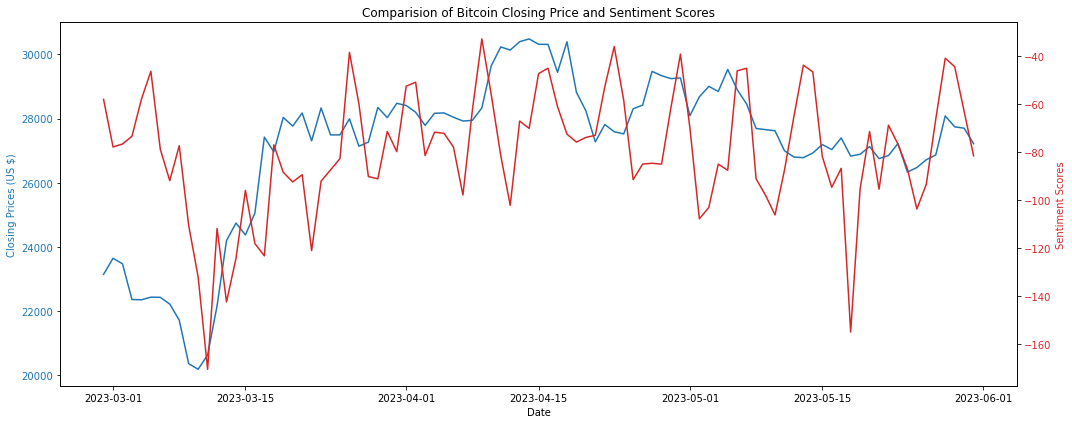

In [9]:
#Time series of Bitcoin and Sentiments Comparison
fig, ax1 = plt.subplots(figsize=(15, 6))

#Closing prices
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Prices (US $)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

#Sentiment scores
color = 'tab:red'
ax2.set_ylabel('Sentiment Scores', color=color)
ax2.plot(merged_df['Date'], merged_df['FinalScore'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparision of Bitcoin Closing Price and Sentiment Scores')

fig.tight_layout()
plt.show()

Correlation between BTC Close Prices and Sentiment Scores: 0.35770122820924993
P-value: 0.0004313600597508819


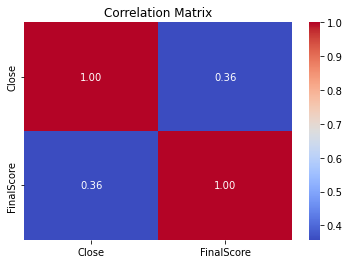

In [10]:
#Correlation - Pearson
merged_df.dropna(inplace=True)

#Correlation matrix
correlation = merged_df[['Close', 'FinalScore']].corr()
correlation_val, p_val = pearsonr(merged_df['Close'], merged_df['FinalScore'])
print("Correlation between BTC Close Prices and Sentiment Scores:", correlation_val)
print("P-value:", p_val)

#Heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Spearman Correlation between BTC Close Prices and Sentiment Scores: 0.2993643878129569
Spearman P-value: 0.0035558898641066014


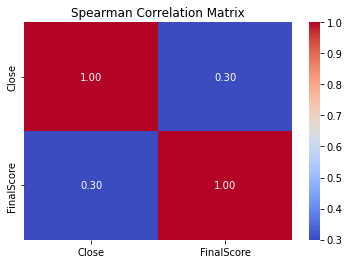

In [11]:
#Correlation - Spearman 
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_spearman, p_val_spearman = spearmanr(merged_df['Close'], merged_df['FinalScore'])

print("Spearman Correlation between BTC Close Prices and Sentiment Scores:", correlation_spearman)
print("Spearman P-value:", p_val_spearman)
correlation_matrix_spearman = merged_df[['Close', 'FinalScore']].corr(method='spearman')

#Heatmap
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

Kendall's tau correlation between BTC Close Prices and Sentiment Scores: 0.20149602618045814
Kendall's tau p-value: 0.004225388627376863


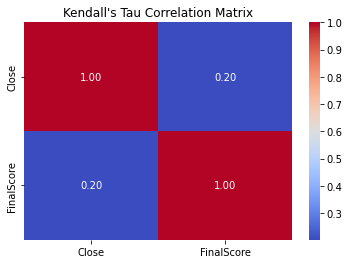

In [12]:
#Correlation - Kendall's Tau
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_kendall = merged_df[['Close', 'FinalScore']].corr(method='kendall')
correlation_val_kendall, p_val_kendall = kendalltau(merged_df['Close'], merged_df['FinalScore'])

print("Kendall's tau correlation between BTC Close Prices and Sentiment Scores:", correlation_val_kendall)
print("Kendall's tau p-value:", p_val_kendall)

#Heatmap
sns.heatmap(correlation_kendall, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Kendall's Tau Correlation Matrix")
plt.show()


In [13]:
#Granger causality test
gc_res = grangercausalitytests(merged_df[['Close', 'FinalScore']], maxlag=1, verbose=False)

p_value_price_sentiment = gc_res[1][0]['ssr_ftest'][1]
p_value_sentiment_price = gc_res[1][0]['ssr_chi2test'][1]

print('P-value of BTC Close Prices causing Sentiment Score:', p_value_price_sentiment)
if p_value_price_sentiment <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from BTC Close Prices to Sentiment Scores.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from BTC Close Prices to Sentiment Scores.")

print('P-value of Sentiment Score causing BTC Close Prices:', p_value_sentiment_price)
if p_value_sentiment_price <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from Sentiment Scores to BTC Close Prices.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from Sentiment Scores to BTC Close Prices.")

P-value of BTC Close Prices causing Sentiment Score: 0.04089210949354342
Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from BTC Close Prices to Sentiment Scores.
P-value of Sentiment Score causing BTC Close Prices: 0.034903021792314866
Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from Sentiment Scores to BTC Close Prices.


In [14]:
#Checking Correlation of Sentiments by lag
sentiment_df= sentiment_df[(sentiment_df['Date'] >='2023-02-28')&(sentiment_df['Date'] <='2023-05-31')]

#Range of lags
min_lag = 1
max_lag = 20

#Correlations
correlations = []
for lag in range(min_lag, max_lag + 1):
    lagged_sentiment_scores = sentiment_df['FinalScore'][:-lag]
    lagged_closing_prices = btc['Close'][lag:]

    correlation, _ = pearsonr(lagged_closing_prices, lagged_sentiment_scores)
    correlations.append(correlation)

for lag, correlation in zip(range(min_lag, max_lag + 1), correlations):
    print(f"Correlation for lag {lag}: {correlation}")

Correlation for lag 1: 0.2876649373948964
Correlation for lag 2: 0.2279717517455078
Correlation for lag 3: 0.17544833540791988
Correlation for lag 4: 0.11353297727063436
Correlation for lag 5: 0.09793224124994816
Correlation for lag 6: 0.03876983341887246
Correlation for lag 7: -0.00699338036273709
Correlation for lag 8: -0.00837412185011537
Correlation for lag 9: 0.015186725862870627
Correlation for lag 10: -0.014717526484601484
Correlation for lag 11: 0.011808523254710303
Correlation for lag 12: 0.021962275327871657
Correlation for lag 13: 0.07492900575944907
Correlation for lag 14: 0.11595898082010474
Correlation for lag 15: 0.09737089349987696
Correlation for lag 16: 0.1314994590915487
Correlation for lag 17: 0.13776568249593976
Correlation for lag 18: 0.026561807468636418
Correlation for lag 19: -0.013970084705384276
Correlation for lag 20: -0.08178978972871259


In [15]:
sentiment_df_2= sentiment_df_2[(sentiment_df_2['Date'] >='2023-02-28')&(sentiment_df_2['Date'] <='2023-05-31')]
sentiment_df_2 = sentiment_df_2.drop('Unnamed: 0', axis=1)
sentiment_df_2

,Date,FinalScore
1,2023-02-28,-58.008373
2,2023-03-01,-77.803071
3,2023-03-02,-76.579328
4,2023-03-03,-73.377458
5,2023-03-04,-57.974046
...,...,...
89,2023-05-27,-66.212404
90,2023-05-28,-40.889290
91,2023-05-29,-44.392002
92,2023-05-30,-63.050229


In [16]:
sentiment_df_2['Lagged_score'] = sentiment_df_2['FinalScore'].shift(1)
sentiment_df_2 = sentiment_df_2.drop(sentiment_df_2.index[0])
sentiment_df_2= sentiment_df_2.reset_index()
sentiment_df_2 = sentiment_df_2.drop('index', axis=1)
sentiment_df_2

,Date,FinalScore,Lagged_score
0,2023-03-01,-77.803071,-58.008373
1,2023-03-02,-76.579328,-77.803071
2,2023-03-03,-73.377458,-76.579328
3,2023-03-04,-57.974046,-73.377458
4,2023-03-05,-46.310909,-57.974046
...,...,...,...
87,2023-05-27,-66.212404,-93.328212
88,2023-05-28,-40.889290,-66.212404
89,2023-05-29,-44.392002,-40.889290
90,2023-05-30,-63.050229,-44.392002


In [17]:
# Merging the extracted columns into a new dataframe
merged_df_2 = pd.merge(btc, sentiment_df_2, left_index=True, right_on='Date', how='inner')
merged_df_2

,Open,High,Low,Close,Adj Close,Volume,Date,FinalScore,Lagged_score
0,23150.929688,23880.632812,23088.626953,23646.550781,23646.550781,24662841200,2023-03-01,-77.803071,-58.008373
1,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516,2023-03-02,-76.579328,-77.803071
2,23476.632812,23479.347656,22213.238281,22362.679688,22362.679688,26062404610,2023-03-03,-73.377458,-76.579328
3,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913,2023-03-04,-57.974046,-73.377458
4,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,13317001733,2023-03-05,-46.310909,-57.974046
...,...,...,...,...,...,...,...,...,...
87,26720.181641,26888.882812,26621.140625,26868.353516,26868.353516,7892015141,2023-05-27,-66.212404,-93.328212
88,26871.158203,28193.449219,26802.751953,28085.646484,28085.646484,14545229578,2023-05-28,-40.889290,-66.212404
89,28075.591797,28432.039062,27563.876953,27745.884766,27745.884766,15181308984,2023-05-29,-44.392002,-40.889290
90,27745.123047,28044.759766,27588.501953,27702.349609,27702.349609,13251081851,2023-05-30,-63.050229,-44.392002


In [18]:
#Extracting Relevant Columns
merged_df_2= merged_df_2[['Date','Close','Lagged_score','FinalScore']]
merged_df_2

,Date,Close,Lagged_score,FinalScore
0,2023-03-01,23646.550781,-58.008373,-77.803071
1,2023-03-02,23475.466797,-77.803071,-76.579328
2,2023-03-03,22362.679688,-76.579328,-73.377458
3,2023-03-04,22353.349609,-73.377458,-57.974046
4,2023-03-05,22435.513672,-57.974046,-46.310909
...,...,...,...,...
87,2023-05-27,26868.353516,-93.328212,-66.212404
88,2023-05-28,28085.646484,-66.212404,-40.889290
89,2023-05-29,27745.884766,-40.889290,-44.392002
90,2023-05-30,27702.349609,-44.392002,-63.050229


In [19]:
#Fitting Models
def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return "{:.2f}%".format(mape)

In [25]:
#XGBoost with Hyperparameter Tuning

#One day lagged
merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)
merged_df_2 = merged_df_2.dropna()

#Features
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

train_size = int(0.8 * len(merged_df_2)) 
X_train= X[:train_size]
X_test= X[train_size:]
y_train= y[:train_size]
y_test= y[train_size:]

#hyperparameters to be tuned
param_dist = {
    'n_estimators': [10, 30, 50, 100, 150, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1],
    'min_child_weight': [1, 2, 3, 4, 5, 6]
}

xgb_reg = xgb.XGBRegressor(seed=12)
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1, random_state=42)


#Fit the model
random_search.fit(X_train, y_train)

#Finding the best estimator and predict on the test set
best_xgb_reg = random_search.best_estimator_

y_pred = best_xgb_reg.predict(X_test)

#Evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Best Parameters: {random_search.best_params_}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.25, 'gamma': 0.2, 'colsample_bytree': 0.5}
Root Mean Squared Error: 953.3140072844383
Mean Absolute Error: 692.3745659722222
Mean Absolute Percentage Error: 2.56%


In [26]:

X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values
XGB_result_df = pd.DataFrame({'Date': X_test['Date'].values, 'Close': y_test.values, 'Predicted_Bitcoin_Price': y_pred})

#Adding new columns for the direction of the actual and predicted prices
XGB_result_df['Actual_Direction'] = np.where(XGB_result_df['Close'] > XGB_result_df['Close'].shift(1), 'Up', 'Down')
XGB_result_df['Predicted_Direction'] = np.where(XGB_result_df['Predicted_Bitcoin_Price'] > XGB_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(XGB_result_df.head())

#Comparing 'Actual_Direction' and 'Predicted_Direction' columns
matches = XGB_result_df['Actual_Direction'] == XGB_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             26293.042969             Down   
1 2023-05-15  27192.693359             27897.984375               Up   
2 2023-05-16  27036.650391             27688.089844             Down   
3 2023-05-17  27398.802734             26888.773438               Up   
4 2023-05-18  26832.208984             27338.982422             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                Down  
3                Down  
4                  Up  
Accuracy: 55.55555555555556%


C:\Users\felix\AppData\Local\Temp\ipykernel_27152\2692674366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values


In [27]:
XGB_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/bitcoin_op.csv")

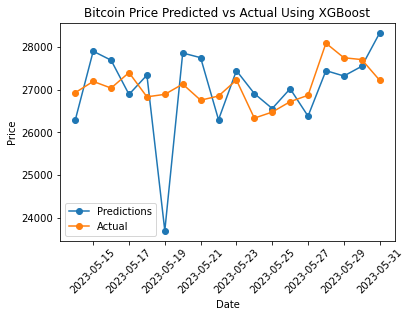

In [28]:

predictions = XGB_result_df['Predicted_Bitcoin_Price']
actual_values = XGB_result_df['Close']

# Plotting the line graph
plt.plot(XGB_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(XGB_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Bitcoin Price Predicted vs Actual Using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

# Displaying the plot
plt.show()

In [29]:
#Gated Reccurrent Unit

np.random.seed(44)
tf.random.set_seed(44)
random.seed(44)

# Scaling the input features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(merged_df_2[['Lagged_score', 'Lagged_closing_price']])
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(merged_df_2[['Close']])

X = X_scaled
y = y_scaled


split_ratio = 0.8
split_idx = int(split_ratio * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

#Building the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50))
model.add(Dense(1))

#Compiling the GRU
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64)


y_pred = model.predict(X_test)

y_test_original = target_scaler.inverse_transform(y_test)
y_pred_original = target_scaler.inverse_transform(y_pred)


rmse = sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 10s 15ms/step - loss: 0.5049
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4414
Epoch 3/50
2/2 [==============================] - 0s 0s/step - loss: 0.3828
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3282
Epoch 5/50
2/2 [==============================] - 0s 15ms/step - loss: 0.2775
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.2302
Epoch 7/50
2/2 [==============================] - 0s 0s/step - loss: 0.1876
Epoch 8/50
2/2 [==============================] - 0s 16ms/step - loss: 0.1491
Epoch 9/50
2/2 [==============================] - 0s 16ms/step - loss: 0.1147
Epoch 10/50
2/2 [==============================] - 0s 0s/step - loss: 0.0857
Epoch 11/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0622
Epoch 12/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0443
Epoch 13/50
2/2 [==============================] - 0s 22ms/step - 

In [30]:

y_test = pd.DataFrame(y_test_original, columns=['Values'])
y_pred= pd.DataFrame(y_pred_original, columns=['Values'])

In [31]:
GRU_result_df = pd.DataFrame({'Date':merged_df_2['Date'].iloc[len(y_train):].values , 'Close': y_test['Values'].values, 'Predicted_Bitcoin_Price': y_pred['Values'].values})

GRU_result_df['Actual_Direction'] = np.where(GRU_result_df['Close'] > GRU_result_df['Close'].shift(1), 'Up', 'Down')
GRU_result_df['Predicted_Direction'] = np.where(GRU_result_df['Predicted_Bitcoin_Price'] > GRU_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(GRU_result_df.head())

matches_test = GRU_result_df['Actual_Direction'] == GRU_result_df['Predicted_Direction']
accuracy_test = (matches_test.sum() / len(matches_test)) * 100
print(f'Accuracy for Test Data: {accuracy_test}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             27641.583984             Down   
1 2023-05-15  27192.693359             27686.896484               Up   
2 2023-05-16  27036.650391             27425.132812             Down   
3 2023-05-17  27398.802734             27192.628906               Up   
4 2023-05-18  26832.208984             27474.642578             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                Down  
3                Down  
4                  Up  
Accuracy for Test Data: 50.0%


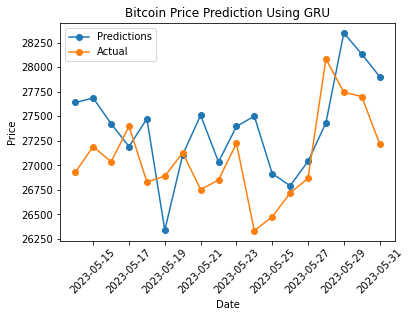

In [32]:
predictions = GRU_result_df['Predicted_Bitcoin_Price']
actual_values = GRU_result_df['Close']

plt.plot(GRU_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(GRU_result_df['Date'], actual_values, marker='o', label='Actual')


plt.title('Bitcoin Price Prediction Using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [33]:
#Holt's Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

seasonal_periods = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30] 

best_model = None
best_rmse = float('inf')

for period in seasonal_periods:
    model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=period)
    model_fit = model.fit()

    y_pred = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model_fit
        best_seasonal_period = period

print("Best Seasonal Period:", best_seasonal_period)
print("Best RMSE:", best_rmse)


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index

Best Seasonal Period: 8
Best RMSE: 483.3450420845732


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimizatio

In [34]:
#Holtz Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Fit the Holt's Winters model
model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=8)
model_fit = model.fit()


y_pred = model_fit.forecast(len(y_test))

#Evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Root Mean Squared Error: 562.2352329893945
Mean Absolute Error: 438.5569003974732
Mean Absolute Percentage Error: 0.91%


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [35]:

HW_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):],
    'Close': y_test.values,
    'Predicted_Bitcoin_Price': y_pred.values
})

HW_result_df['Actual_Direction'] = np.where(HW_result_df['Close'] > HW_result_df['Close'].shift(1), 'Up', 'Down')
HW_result_df['Predicted_Direction'] = np.where(HW_result_df['Predicted_Bitcoin_Price'] > HW_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')

print(HW_result_df)


matches = HW_result_df['Actual_Direction'] == HW_result_df['Predicted_Direction']

accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy for Test Data: {accuracy}%')

         Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
74 2023-05-14  26930.638672             26702.869206             Down   
75 2023-05-15  27192.693359             26753.664693               Up   
76 2023-05-16  27036.650391             27199.961427             Down   
77 2023-05-17  27398.802734             26828.028968               Up   
78 2023-05-18  26832.208984             26840.367874             Down   
79 2023-05-19  26890.128906             26631.924316               Up   
80 2023-05-20  27129.585938             26820.464102               Up   
81 2023-05-21  26753.826172             26784.013819             Down   
82 2023-05-22  26851.277344             26702.869206               Up   
83 2023-05-23  27225.726562             26753.664693               Up   
84 2023-05-24  26334.818359             27199.961427             Down   
85 2023-05-25  26476.207031             26828.028968               Up   
86 2023-05-26  26719.291016             26840.36787

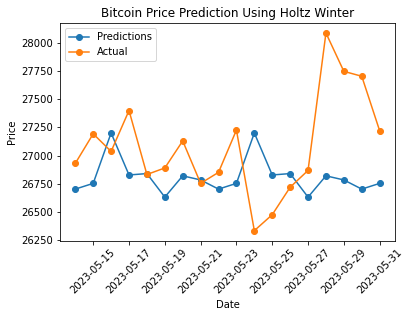

In [36]:
predictions = HW_result_df['Predicted_Bitcoin_Price']
actual_values = HW_result_df['Close']

plt.plot(HW_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(HW_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Bitcoin Price Prediction Using Holtz Winter')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [37]:
#SVR- Support Vector Regression

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = SVR(kernel='rbf', C=1e2, gamma=0.1)

#Fit the model
model.fit(X_train, y_train.ravel())

train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 542.7337179819883
Mean Absolute Error: 425.0811434735703
Mean Absolute Percentage Error: 1.57%


In [38]:
SVR_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Bitcoin_Price': test_predict.flatten()
})


SVR_result_df['Actual_Direction'] = np.where(SVR_result_df['Close'] > SVR_result_df['Close'].shift(1), 'Up', 'Down')
SVR_result_df['Predicted_Direction'] = np.where(SVR_result_df['Predicted_Bitcoin_Price'] > SVR_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')

print(SVR_result_df.head())


matches = SVR_result_df['Actual_Direction'] == SVR_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             26921.218176             Down   
1 2023-05-15  27192.693359             27071.113610               Up   
2 2023-05-16  27036.650391             27465.020567             Down   
3 2023-05-17  27398.802734             27415.435148               Up   
4 2023-05-18  26832.208984             27664.459910             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                  Up  
3                Down  
4                  Up  
Accuracy: 33.33333333333333%


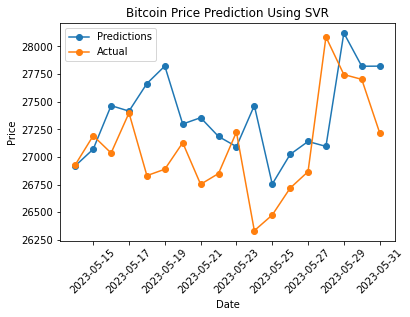

In [39]:
predictions = SVR_result_df['Predicted_Bitcoin_Price']
actual_values = SVR_result_df['Close']

plt.plot(SVR_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(SVR_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Bitcoin Price Prediction Using SVR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [41]:
#LightGBM

#Features
X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Building LightGBM Model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

lgb_train = lgb.Dataset(X_train, y_train.ravel())
lgb_eval = lgb.Dataset(X_test, y_test.ravel(), reference=lgb_train)

model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=200)

train_predict = model.predict(X_train, num_iteration=model.best_iteration).reshape(-1, 1)
test_predict = model.predict(X_test, num_iteration=model.best_iteration).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 2
[LightGBM] [Info] Start training from score 0.699815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [42]:
LightGBM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Bitcoin_Price': test_predict.flatten()
})


LightGBM_result_df['Actual_Direction'] = np.where(LightGBM_result_df['Close'] > 
                                                  LightGBM_result_df['Close'].shift(1), 'Up', 'Down')
LightGBM_result_df['Predicted_Direction'] = np.where(LightGBM_result_df['Predicted_Bitcoin_Price'] > 
                                                     LightGBM_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(LightGBM_result_df.head())


matches = LightGBM_result_df['Actual_Direction'] == LightGBM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             27025.562055             Down   
1 2023-05-15  27192.693359             27025.562055               Up   
2 2023-05-16  27036.650391             27025.562055             Down   
3 2023-05-17  27398.802734             27025.562055               Up   
4 2023-05-18  26832.208984             27025.562055             Down   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                Down  
4                Down  
Accuracy: 38.88888888888889%


In [43]:
#Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(50))
model.add(Dense(1))

#Fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 9s 19ms/step - loss: 0.5486
Epoch 2/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5315
Epoch 3/50
2/2 [==============================] - 0s 3ms/step - loss: 0.5147
Epoch 4/50
2/2 [==============================] - 0s 6ms/step - loss: 0.4979
Epoch 5/50
2/2 [==============================] - 0s 16ms/step - loss: 0.4811
Epoch 6/50
2/2 [==============================] - 0s 9ms/step - loss: 0.4641
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 0.4470
Epoch 8/50
2/2 [==============================] - 0s 0s/step - loss: 0.4295
Epoch 9/50
2/2 [==============================] - 0s 9ms/step - loss: 0.4113
Epoch 10/50
2/2 [==============================] - 0s 18ms/step - loss: 0.3925
Epoch 11/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3729
Epoch 12/50
2/2 [==============================] - 0s 8ms/step - loss: 0.3523
Epoch 13/50
2/2 [==============================] - 0s 10ms/step - los

In [44]:
LSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Bitcoin_Price': test_predict.flatten()
})

LSTM_result_df['Actual_Direction'] = np.where(LSTM_result_df['Close'] > LSTM_result_df['Close'].shift(1), 'Up', 'Down')
LSTM_result_df['Predicted_Direction'] = np.where(LSTM_result_df['Predicted_Bitcoin_Price'] > LSTM_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(LSTM_result_df.head())

matches = LSTM_result_df['Actual_Direction'] == LSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             28103.623047             Down   
1 2023-05-15  27192.693359             28093.990234               Up   
2 2023-05-16  27036.650391             27396.720703             Down   
3 2023-05-17  27398.802734             27053.544922               Up   
4 2023-05-18  26832.208984             27359.789062             Down   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                Down  
4                  Up  
Accuracy: 50.0%


In [ ]:
LSTM_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/btc_lstm.csv")

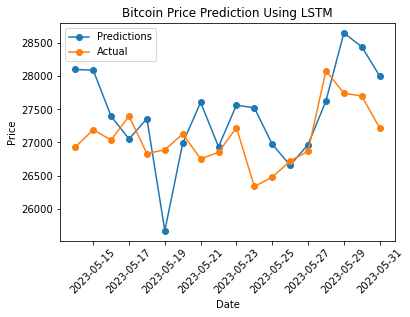

In [45]:
predictions = LSTM_result_df['Predicted_Bitcoin_Price']
actual_values = LSTM_result_df['Close']

plt.plot(LSTM_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(LSTM_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Bitcoin Price Prediction Using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [46]:
#Bidirectional Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()

model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(1, 2))) 
model.add(Dense(1))


#Fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 6s 17ms/step - loss: 0.6073
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.5844
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.5624
Epoch 4/50
2/2 [==============================] - 0s 19ms/step - loss: 0.5413
Epoch 5/50
2/2 [==============================] - 0s 0s/step - loss: 0.5208
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.5008
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4815
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4623
Epoch 9/50
2/2 [==============================] - 0s 16ms/step - loss: 0.4434
Epoch 10/50
2/2 [==============================] - 0s 0s/step - loss: 0.4247
Epoch 11/50
2/2 [==============================] - 0s 16ms/step - loss: 0.4060
Epoch 12/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3873
Epoch 13/50
2/2 [==============================] - 0s 0s/step - loss:

In [47]:
BiLSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Bitcoin_Price': test_predict.flatten()
})

BiLSTM_result_df['Actual_Direction'] = np.where(BiLSTM_result_df['Close'] > BiLSTM_result_df['Close'].shift(1), 'Up', 'Down')
BiLSTM_result_df['Predicted_Direction'] = np.where(BiLSTM_result_df['Predicted_Bitcoin_Price'] > BiLSTM_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(BiLSTM_result_df.head())

matches = BiLSTM_result_df['Actual_Direction'] == BiLSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             28277.966797             Down   
1 2023-05-15  27192.693359             28281.386719               Up   
2 2023-05-16  27036.650391             27614.142578             Down   
3 2023-05-17  27398.802734             27263.869141               Up   
4 2023-05-18  26832.208984             27588.113281             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                Down  
3                Down  
4                  Up  
Accuracy: 55.55555555555556%


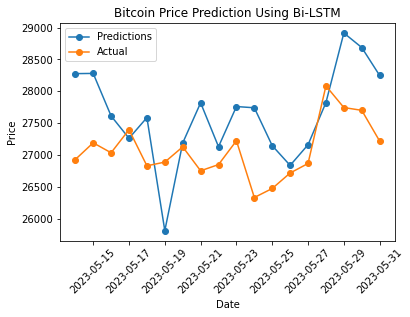

In [48]:
predictions = BiLSTM_result_df['Predicted_Bitcoin_Price']
actual_values = BiLSTM_result_df['Close']

plt.plot(BiLSTM_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(BiLSTM_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Bitcoin Price Prediction Using Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [49]:
BiLSTM_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/btc_bilstm.csv")

In [50]:
#Bi-LSTM

#One day lagged closing price column
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

# Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

# Building LSTM Model
model = Sequential()

model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(1, 1))) 
model.add(Dense(1))

# Fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

# Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 6s 32ms/step - loss: 0.5597
Epoch 2/50
2/2 [==============================] - 0s 9ms/step - loss: 0.5418
Epoch 3/50
2/2 [==============================] - 0s 0s/step - loss: 0.5247
Epoch 4/50
2/2 [==============================] - 0s 8ms/step - loss: 0.5085
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4927
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.4772
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4624
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 0.4478
Epoch 9/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4334
Epoch 10/50
2/2 [==============================] - 0s 16ms/step - loss: 0.4195
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4059
Epoch 12/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3923
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - los

In [51]:
BiLSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Bitcoin_Price': test_predict.flatten()
})


BiLSTM_result_df['Actual_Direction'] = np.where(BiLSTM_result_df['Close'] > BiLSTM_result_df['Close'].shift(1), 'Up', 'Down')
BiLSTM_result_df['Predicted_Direction'] = np.where(BiLSTM_result_df['Predicted_Bitcoin_Price'] > BiLSTM_result_df['Predicted_Bitcoin_Price'].shift(1), 'Up', 'Down')
print(BiLSTM_result_df.head())

matches = BiLSTM_result_df['Actual_Direction'] == BiLSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date         Close  Predicted_Bitcoin_Price Actual_Direction  \
0 2023-05-14  26930.638672             26311.044922             Down   
1 2023-05-15  27192.693359             26381.041016               Up   
2 2023-05-16  27036.650391             26506.669922             Down   
3 2023-05-17  27398.802734             26431.789062               Up   
4 2023-05-18  26832.208984             26605.910156             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                  Up  
3                Down  
4                  Up  
Accuracy: 50.0%


In [52]:
BiLSTM_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/btc_no_score.csv")

In [53]:
result= pd.read_csv("C:/Dissertation/ML Codes Final/ML Output/btc_bilstm.csv")

              precision    recall  f1-score   support

          Up       0.62      0.50      0.56        10
        Down       0.50      0.62      0.56         8

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.56        18
weighted avg       0.57      0.56      0.56        18



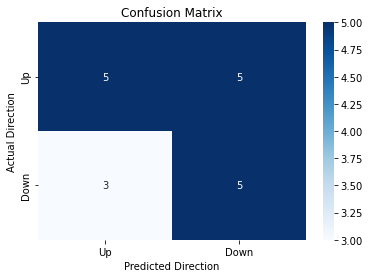

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

report = classification_report(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])
print(report)

cm = confusion_matrix(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Up', 'Down'], yticklabels=['Up', 'Down'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("Actual Direction")
plt.show()